In [1]:
import sys
sys.path.append("c:/users/david/desktop/sandbox")
import pandas as pd
import numpy as np
from pyrecs.train import lightfm_wrapper
from lenskit.datasets import ML100K

%load_ext autoreload
%autoreload 2

c:\users\david\desktop\sandbox\pyrecs\env\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
ml100k = ML100K('../data/movielens-100k')

# Pure CF

In [3]:
ratings = ml100k.ratings.sort_values(by='timestamp')
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['user'] = ratings['user'].astype(str)
ratings['item'] = ratings['item'].astype(str)

print(ratings['timestamp'].describe(datetime_is_numeric=True))
print(ratings.shape)
ratings.head()

count                           100000
mean     1997-12-31 00:40:51.488619904
min                1997-09-20 03:05:10
25%         1997-11-13 19:18:29.500000
50%                1997-12-22 21:42:24
75%                1998-02-23 18:53:04
max                1998-04-22 23:10:38
Name: timestamp, dtype: object
(100000, 4)


,user,item,rating,timestamp
214,259,255,4.0,1997-09-20 03:05:10
83965,259,286,4.0,1997-09-20 03:05:27
43027,259,298,4.0,1997-09-20 03:05:54
21396,259,185,4.0,1997-09-20 03:06:21
82655,259,173,4.0,1997-09-20 03:07:23


In [4]:
train_df = ratings.iloc[:90000].copy()
test_df = ratings.iloc[90000:].copy()

train_df.shape, test_df.shape

((90000, 4), (10000, 4))

In [5]:
train_df['user'].nunique(), test_df['user'].nunique(), len(set(train_df['user'].unique()) & set(test_df['user'].unique()))

(867, 166, 90)

In [6]:
train_df['item'].nunique(), test_df['item'].nunique(), len(set(train_df['item'].unique()) & set(test_df['item'].unique()))

(1637, 1343, 1298)

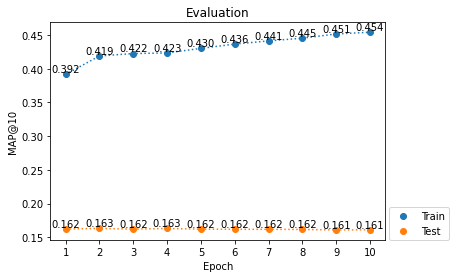

Training: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.84s/it]


In [8]:
model_kwargs = {
    'no_components':32,
    'learning_rate':0.005,
    'loss':'warp',
    'random_state':42
}
train_kwargs = {
    'num_epochs':10,
    'num_threads':1,
    'eval_epochs':'all',
    'plot':True
}
lfm = lightfm_wrapper.LightFM(users_col='user', items_col='item', interactions_type='ones',
                              model_kwargs=model_kwargs, train_kwargs=train_kwargs,
                              n_recs=10, tfrs_prediction_batch_size=128, fill_most_popular=True, 
                              normalize_features=False, exclude_seen_items=False, remove_factor_biases=False)

lfm.run(train_df=train_df, test_df=test_df)

In [10]:
len(lfm.predictions_dict), len(set([str(v) for v in lfm.predictions_dict.values()]))

(867, 111)

# Hybrid CF

In [11]:
users = ml100k.users.reset_index()
users['user'] = users['user'].astype(str)
users['user_copy'] = users['user'].copy()
users['occupation'] = users['occupation'].astype(str)
print(users.shape)
display(users.head())


movies = ml100k.movies.reset_index()
movies['item'] = movies['item'].astype(str)
movies['item_copy'] = movies['item'].copy()
columns = [c for c in movies.columns if c not in ['item','title','release','vidrelease','imdb','item_copy']]
ind2col = dict(zip(range(len(columns)), columns))
movies['genres'] = movies[columns].apply(lambda x: [ind2col[i] for i in np.where(x != 0)[0]], axis=1)
movies.drop(columns, axis=1, inplace=True)

def extract_year(x):
    try:
        return int(x.split('(')[-1].rstrip(')'))
    except:
        return 0
movies['year'] = movies['title'].apply(extract_year)

print(movies.shape)
display(movies.head())

(943, 6)


,user,age,gender,occupation,zip,user_copy
0,1,24,M,technician,85711,1
1,2,53,F,other,94043,2
2,3,23,M,writer,32067,3
3,4,24,M,technician,43537,4
4,5,33,F,other,15213,5


(1682, 8)


,item,title,release,vidrelease,imdb,item_copy,genres,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1,"[Animation, Children's, Comedy]",1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,2,"[Action, Adventure, Thriller]",1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,3,[Thriller],1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,4,"[Action, Comedy, Drama]",1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),5,"[Crime, Drama, Thriller]",1995


In [12]:
cols = ['age','gender','occupation','user_copy','user']
train_user_features_dict = users[users['user'].isin(train_df['user'].unique())][cols].set_index('user').to_dict(orient='index')
test_user_features_dict = users[users['user'].isin(test_df['user'].unique()) 
                                & ~users['user'].isin(train_df['user'].unique())][cols].set_index('user').to_dict(orient='index')

len(train_user_features_dict), len(test_user_features_dict)

(867, 76)

In [13]:
cols = ['genres','year','item_copy','item']
train_item_features_dict = movies[movies['item'].isin(train_df['item'].unique())][cols].set_index('item').to_dict(orient='index')
test_item_features_dict = movies[movies['item'].isin(test_df['item'].unique()) 
                                & ~movies['item'].isin(train_df['item'].unique())][cols].set_index('item').to_dict(orient='index')

len(train_item_features_dict), len(test_item_features_dict)

(1637, 45)

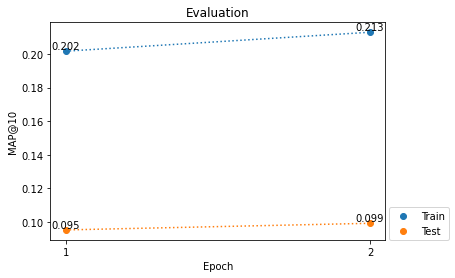

Training: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.31s/it]


In [ ]:
model_kwargs = {
    'no_components':32,
    'learning_rate':0.05,
    'loss':'warp',
    'random_state':42
}
train_kwargs = {
    'num_epochs':2,
    'num_threads':1,
    'eval_epochs':'all',
    'plot':True
}
lfm = lightfm_wrapper.LightFM(users_col='user', items_col='item', interactions_type='ones',
                              model_kwargs=model_kwargs, train_kwargs=train_kwargs,
                              n_recs=10, tfrs_prediction_batch_size=128, fill_most_popular=True, 
                              normalize_features=True, exclude_seen_items=False, remove_factor_biases=False)

lfm.run(train_df=train_df, test_df=test_df,
        train_user_features_dict=train_user_features_dict, 
        train_item_features_dict=train_item_features_dict,
        test_user_features_dict=test_user_features_dict, 
        test_item_features_dict=test_item_features_dict)

In [15]:
# Format train/test user/item representations and identifiers
train_user_factors, train_user_identifiers = lfm._get_feature_representations(dataset='train', feature_type='user')
train_item_factors, train_item_identifiers = lfm._get_feature_representations(dataset='train', feature_type='item')
test_item_identifiers, test_user_identifiers = [], []
if lfm.test_user_features_matrix is not None:
    test_user_factors, test_user_identifiers = lfm._get_feature_representations(dataset='test', feature_type='user')
    user_embeddings = np.vstack([train_user_factors, test_user_factors])
else:
    user_embeddings = train_user_factors
if lfm.test_item_features_matrix is not None:
    test_item_factors, test_item_identifiers = lfm._get_feature_representations(dataset='test', feature_type='item')
    item_embeddings = np.vstack([train_item_factors, test_item_factors])
else:
    item_embeddings = train_item_factors
user_identifiers = train_user_identifiers+test_user_identifiers
item_identifiers = train_item_identifiers+test_item_identifiers

In [17]:
import tensorflow_recommenders  as tfrs
import tensorflow as tf
import itertools

In [80]:
from tqdm import tqdm

In [106]:
n_recs = 10
prediction_batch_size = 128

# Create tfrs.Streaming instance
stream = tfrs.layers.factorized_top_k.Streaming()
stream.index_from_dataset(
tf.data.Dataset.from_tensors({
        'identifier':item_identifiers,
        'embedding':item_embeddings.astype('float32')
    }).map(lambda x: (x['identifier'], x['embedding']))
)

# Get batched predictions
if len(user_embeddings.shape) == 1:
    user_embeddings = user_embeddings[None,:]
if len(lfm.train_dict) == 0:
    pred_func = lambda x: stream(tf.squeeze(x['embedding']), k=n_recs)[1]
    exclusions = ['']*len(user_identifiers[:3])
else:
    pred_func = lambda x: (x['identifier'], 
                           stream.query_with_exclusions(tf.squeeze(x['embedding']), 
                                                        exclusions=x['exclusions'],
                                                        k=n_recs)[1])
    max_exclude_len = max([len(v) for v in lfm.train_dict.values()])
    exclusions = []
    for user_id in user_identifiers[:3]:
        temp_vec = ['']*max_exclude_len
        for n, item in enumerate(lfm.train_dict.get(user_id, [])):
            temp_vec[n] = item
        exclusions.append(temp_vec)
predictions = tf.data.Dataset.from_tensor_slices({
                'identifier':user_identifiers[:3], 
                'embedding':user_embeddings[:3].astype('float32'),
                'exclusions':exclusions
            })\
            .batch(prediction_batch_size)\
            .map(pred_func)

# TODO: Fix this part, it's too slow. Just do batching in the prediction loop without tf
# # Format predictions
# formatted_predictions = {}
# for i in tqdm(predictions):
#     formatted_predictions.update(dict(zip(tf.squeeze(i[0]).numpy().astype(str), tf.squeeze(i[1]).numpy().astype(str))))

In [ ]:
for i in predictions.map(lambda x, y: tf.squeeze(x[0])).as_numpy_iterator():
    print(i)

[b'50' b'636' b'164' b'252' b'358' b'831' b'426' b'498' b'260' b'802']


In [99]:
predictions.take(1).reduce(initial_state=0, reduce_func=lambda x, _: x)

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [101]:
predictions.take(1).map(lambda x: x)

TypeError: in user code:


    TypeError: <lambda>() takes 1 positional argument but 2 were given


In [100]:
predictions.map?

Signature:
predictions.map(
    map_func,
    num_parallel_calls=None,
    deterministic=None,
    name=None,
)
Docstring:
Maps `map_func` across the elements of this dataset.

This transformation applies `map_func` to each element of this dataset, and
returns a new dataset containing the transformed elements, in the same
order as they appeared in the input. `map_func` can be used to change both
the values and the structure of a dataset's elements. Supported structure
constructs are documented
[here](https://www.tensorflow.org/guide/data#dataset_structure).

For example, `map` can be used for adding 1 to each element, or projecting a
subset of element components.

>>> dataset = Dataset.range(1, 6)  # ==> [ 1, 2, 3, 4, 5 ]
>>> dataset = dataset.map(lambda x: x + 1)
>>> list(dataset.as_numpy_iterator())
[2, 3, 4, 5, 6]

The input signature of `map_func` is determined by the structure of each
element in this dataset.

>>> dataset = Dataset.range(5)
>>> # `map_func` takes a single argument

In [ ]:
predictions.take(1).reduce

In [89]:
predictions.apply(lambda x: x.values)

AttributeError: 'MapDataset' object has no attribute 'values'